### Toxic Comments Classification Dataset
Group: Jaime Paz Lopes, Filippo Bidoia, Daniel Paul Emmanuel Undie

**Description:**
The Toxic Comments Classification Dataset consists of a large number of Wikipedia comments which have been labeled by human raters for toxic behavior.

**Aim:**
*   Starting from the Dataset make a study about the content of the dataset (exploratory analysis) (size, empty values, tokenization, etc) 
*   Solve the related categorization problem with respect to the six (6) classes.
* Explain the results

**Dataset:**

Wikipedia comments which have been labeled by human raters for toxic behavior. 
The types of toxicity are:
*   identity_hate,
*   insult,
*   obscene,
*   severe_toxic,
*   threat,
*   toxic

**Files:**
*   train.csv - the training set, contains comments with their binary labels
*   test.csv - the test set (not labeled)

**Technologies used:** 
*   Keras
*   Nltk stopwords
*   Pandas
*   SKlearn



**Content:**
* Introduction
* Import libraries
* Read the data
* Dataset Information
* Cleaning Dataset
* Lemmatisation
* Tokenization
* Padding
* Training NN
* Running algorithm
* Results
* Conclusion



**Performing imports and loading the dataset**

We are loading the dataset in the environment. We decided to work together on the google collab environment. 

But this file works as a stand-alone version.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import spacy
import nltk
from nltk.corpus import stopwords 
import spacy

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix

from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer

from wordcloud import WordCloud
from collections import Counter

import random
import string
import os.path
import re
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
'''from google.colab import drive
drive.mount('/content/gdrive')'''

"from google.colab import drive\ndrive.mount('/content/gdrive')"

In [3]:
train_path = "train_preprocessed.csv"
df = pd.read_csv(train_path)

**Dataset Infomation**

Standard visualization of the starting dataset to understand the division of classes and other general info such as null values.

In [4]:
#Info about the dataset, 159571 entries (all not null as seem before), types of the data (text and string are object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   comment_text   159571 non-null  object 
 1   id             159571 non-null  object 
 2   identity_hate  159571 non-null  float64
 3   insult         159571 non-null  float64
 4   obscene        159571 non-null  float64
 5   set            159571 non-null  object 
 6   severe_toxic   159571 non-null  float64
 7   threat         159571 non-null  float64
 8   toxic          159571 non-null  float64
 9   toxicity       159571 non-null  float64
dtypes: float64(7), object(3)
memory usage: 12.2+ MB


In [5]:
#cheching for missing values
df.isnull().sum()

comment_text     0
id               0
identity_hate    0
insult           0
obscene          0
set              0
severe_toxic     0
threat           0
toxic            0
toxicity         0
dtype: int64

In [6]:
#all categories are 0 or 1
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
for cat in labels:
  print(cat, " ", df[cat].unique())

toxic   [0. 1.]
severe_toxic   [0. 1.]
obscene   [0. 1.]
threat   [0. 1.]
insult   [0. 1.]
identity_hate   [0. 1.]


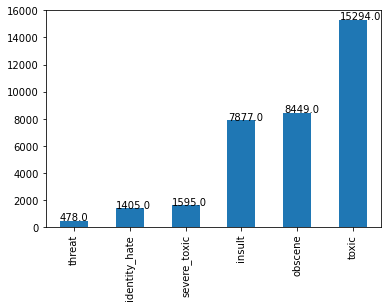

In [7]:
# get the count of every category and plot
ax = df[labels].sum().sort_values().plot.bar()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

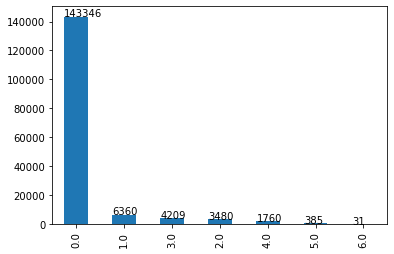

In [8]:
#plot toxicity count, most comments with toxicity are classified in more than one category
ax = df["toxicity"].value_counts().plot.bar()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

**Class interaction visualization**

We are trying to understand how the relevant comment are distributed between the classes. We check the different combination lokking for high connection between different classes that could make harder the correctly identification of the kind of toxicity.


In [9]:
#get all combinations of categories, toxic has a lot of intersection with other categories
df.groupby(labels).size().sort_values(ascending=False).reset_index()\
                      .rename(columns={0: 'count'})

toxic  severe_toxic  obscene  threat  insult  identity_hate   count
0     0.0           0.0      0.0     0.0     0.0            0.0  143346
1     1.0           0.0      0.0     0.0     0.0            0.0    5666
2     1.0           0.0      1.0     0.0     1.0            0.0    3800
3     1.0           0.0      1.0     0.0     0.0            0.0    1758
4     1.0           0.0      0.0     0.0     1.0            0.0    1215
5     1.0           1.0      1.0     0.0     1.0            0.0     989
6     1.0           0.0      1.0     0.0     1.0            1.0     618
7     0.0           0.0      1.0     0.0     0.0            0.0     317
8     0.0           0.0      0.0     0.0     1.0            0.0     301
9     1.0           1.0      1.0     0.0     1.0            1.0     265
10    0.0           0.0      1.0     0.0     1.0            0.0     181
11    1.0           1.0      1.0     0.0     0.0            0.0     158
12    1.0           0.0      0.0     0.0     0.0            1.0     136
13    1.0           0.0      0.0     0.0     1.0            1.0     134
14    1.0           0.0      1.0     1.0     1.0            0.0     131
15    1.0           0.0      0.0     1.0     0.0            0.0     113
16    1.0           1.0      1.0     1.0     1.0            0.0      64
17    1.0           0.0      1.0     1.0     1.0            1.0      56
18    0.0           0.0      0.0     0.0     0.0            1.0      54
19    1.0           1.0      0.0     0.0     0.0            0.0      41
20    1.0           0.0      1.0     0.0     0.0            1.0      35
21    1.0           1.0      1.0     1.0     1.0            1.0      31
22    0.0           0.0      0.0     0.0     1.0            1.0      28
23    0.0           0.0      0.0     1.0     0.0            0.0      22
24    0.0           0.0      1.0     0.0     1.0            1.0      18
25    1.0           0.0      0.0     1.0     1.0            0.0      16
26    1.0           1.0      0.0     0.0     1.0            0.0      14
27    1.0           1.0      0.0     1.0     0.0            0.0      11
28    1.0           0.0      1.0     1.0     0.0            0.0      11
29    1.0           0.0      0.0     1.0     0.0            1.0       7
30    1.0           1.0      0.0     0.0     1.0            1.0       7
31    1.0           1.0      1.0     0.0     0.0            1.0       6
32    1.0           1.0      1.0     1.0     0.0            0.0       4
33    1.0           1.0      0.0     0.0     0.0            1.0       3
34    0.0           0.0      1.0     0.0     0.0            1.0       3
35    0.0           0.0      0.0     1.0     1.0            0.0       3
36    1.0           0.0      0.0     1.0     1.0            1.0       3
37    0.0           0.0      1.0     1.0     1.0            0.0       2
38    0.0           0.0      1.0     1.0     0.0            0.0       2
39    1.0           1.0      0.0     1.0     0.0            1.0       1
40    1.0           1.0      0.0     1.0     1.0            0.0       1

In [10]:
#here is more obvious this intersection
df[df["toxic"]==1].groupby(labels).size().sort_values(ascending=False).reset_index()\
                      .rename(columns={0: 'count'})

toxic  severe_toxic  obscene  threat  insult  identity_hate  count
0     1.0           0.0      0.0     0.0     0.0            0.0   5666
1     1.0           0.0      1.0     0.0     1.0            0.0   3800
2     1.0           0.0      1.0     0.0     0.0            0.0   1758
3     1.0           0.0      0.0     0.0     1.0            0.0   1215
4     1.0           1.0      1.0     0.0     1.0            0.0    989
5     1.0           0.0      1.0     0.0     1.0            1.0    618
6     1.0           1.0      1.0     0.0     1.0            1.0    265
7     1.0           1.0      1.0     0.0     0.0            0.0    158
8     1.0           0.0      0.0     0.0     0.0            1.0    136
9     1.0           0.0      0.0     0.0     1.0            1.0    134
10    1.0           0.0      1.0     1.0     1.0            0.0    131
11    1.0           0.0      0.0     1.0     0.0            0.0    113
12    1.0           1.0      1.0     1.0     1.0            0.0     64
13    1.0           0.0      1.0     1.0     1.0            1.0     56
14    1.0           1.0      0.0     0.0     0.0            0.0     41
15    1.0           0.0      1.0     0.0     0.0            1.0     35
16    1.0           1.0      1.0     1.0     1.0            1.0     31
17    1.0           0.0      0.0     1.0     1.0            0.0     16
18    1.0           1.0      0.0     0.0     1.0            0.0     14
19    1.0           0.0      1.0     1.0     0.0            0.0     11
20    1.0           1.0      0.0     1.0     0.0            0.0     11
21    1.0           1.0      0.0     0.0     1.0            1.0      7
22    1.0           0.0      0.0     1.0     0.0            1.0      7
23    1.0           1.0      1.0     0.0     0.0            1.0      6
24    1.0           1.0      1.0     1.0     0.0            0.0      4
25    1.0           1.0      0.0     0.0     0.0            1.0      3
26    1.0           0.0      0.0     1.0     1.0            1.0      3
27    1.0           1.0      0.0     1.0     0.0            1.0      1
28    1.0           1.0      0.0     1.0     1.0            0.0      1

In [11]:
#non toxic comments are the smaller part
df[df["toxic"]==0].groupby(labels).size().sort_values(ascending=False).reset_index()\
                      .rename(columns={0: 'count'})

toxic  severe_toxic  obscene  threat  insult  identity_hate   count
0     0.0           0.0      0.0     0.0     0.0            0.0  143346
1     0.0           0.0      1.0     0.0     0.0            0.0     317
2     0.0           0.0      0.0     0.0     1.0            0.0     301
3     0.0           0.0      1.0     0.0     1.0            0.0     181
4     0.0           0.0      0.0     0.0     0.0            1.0      54
5     0.0           0.0      0.0     0.0     1.0            1.0      28
6     0.0           0.0      0.0     1.0     0.0            0.0      22
7     0.0           0.0      1.0     0.0     1.0            1.0      18
8     0.0           0.0      1.0     0.0     0.0            1.0       3
9     0.0           0.0      0.0     1.0     1.0            0.0       3
10    0.0           0.0      1.0     1.0     1.0            0.0       2
11    0.0           0.0      1.0     1.0     0.0            0.0       2

In [12]:
#all severe_toxic are also toxic
df.groupby(["toxic", "severe_toxic"]).size().sort_values(ascending=False).reset_index()\
                      .rename(columns={0: 'count'})

toxic  severe_toxic   count
0    0.0           0.0  144277
1    1.0           0.0   13699
2    1.0           1.0    1595

In [13]:
#insult and obscene (the other 2 big categories) have a large intersection
df.groupby(["insult", "obscene"]).size().sort_values(ascending=False).reset_index()\
                      .rename(columns={0: 'count'})

insult  obscene   count
0     0.0      0.0  149400
1     1.0      1.0    6155
2     0.0      1.0    2294
3     1.0      0.0    1722

In [14]:
#looking to the 3 ways intersection
df.groupby(["toxic", "insult", "obscene"]).size().sort_values(ascending=False).reset_index()\
                      .rename(columns={0: 'count'})

toxic  insult  obscene   count
0    0.0     0.0      0.0  143422
1    1.0     0.0      0.0    5978
2    1.0     1.0      1.0    5954
3    1.0     0.0      1.0    1972
4    1.0     1.0      0.0    1390
5    0.0     1.0      0.0     332
6    0.0     0.0      1.0     322
7    0.0     1.0      1.0     201

**Data visualization**

We want to be able to unserstand which are the most used words in our scenario. These words will be the most relevant for our model to undestand the structure of the classes.

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jaime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

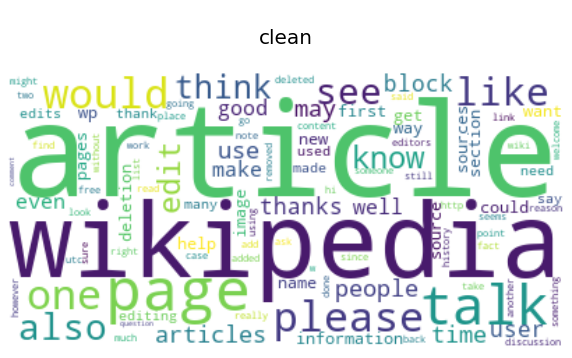

In [16]:
#clean comments wordcloud

stop = stopwords.words('english')
word_counter = {}

# writing a fast cleaning function to wordcloud exibition, later we apply a more complex one
def fast_clean(text):
  text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
  return ' '.join([word for word in text.split() if word not in (stop)])

text = Counter()        

# ... applying the clean-function to each column's comments and ...
df[df["toxicity"] == 0]['comment_text'].apply(lambda t: text.update(fast_clean(t).split()))

# ... combining all to one dataframe
word_counter["clean"] = pd.DataFrame.from_dict(text, orient='index')\
                                    .rename(columns={0: 'count'})\
                                    .sort_values('count', ascending=False)
wc_list = word_counter["clean"]

wordcloud = WordCloud(background_color='white', max_words=100, max_font_size=100, random_state=4)\
                      .generate_from_frequencies(wc_list.to_dict()['count'])

fig = plt.figure(figsize=(10, 8))
plt.title('\n' + "clean" + '\n', fontsize=20)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

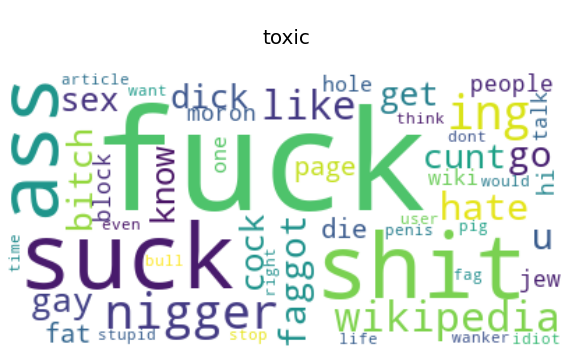

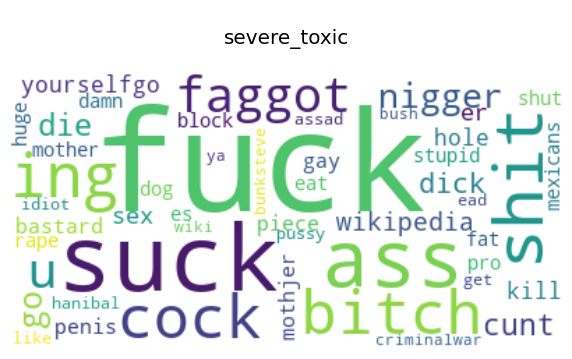

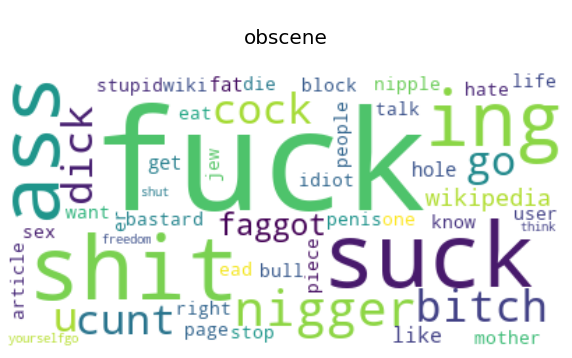

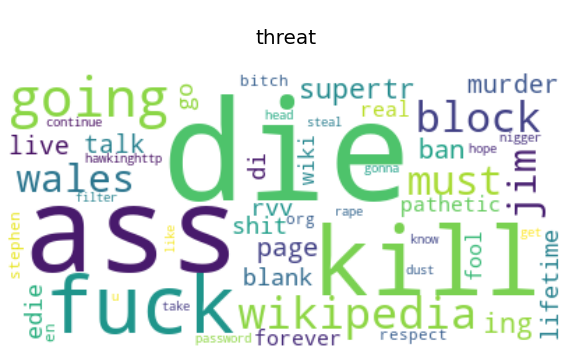

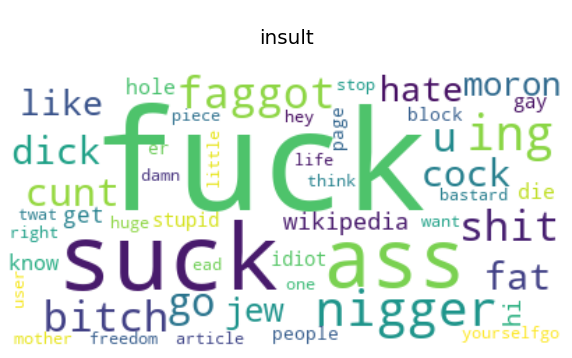

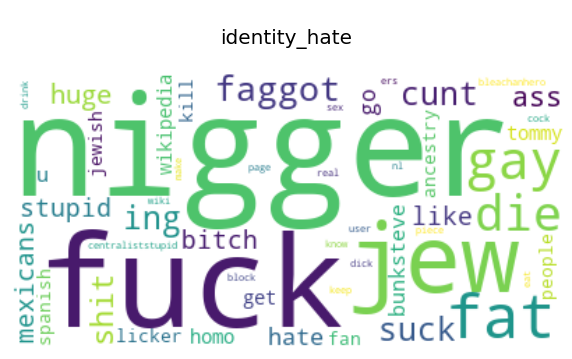

In [17]:
#all categories wordcloud

# define an empty dictionary
word_counter = {}

# iterating through all columns in the dataset...
for col in labels:    
  text = Counter()        

  # ... applying the clean-function to each column's comments and ...
  df[df[col] == 1]['comment_text'].apply(lambda t: text.update(fast_clean(t).split()))

  # ... combining all to one dataframe
  word_counter[col] = pd.DataFrame.from_dict(text, orient='index')\
                                      .rename(columns={0: 'count'})\
                                      .sort_values('count', ascending=False)

# iterating through new df word_counter and creating a WordCloud for each column
for col in word_counter:    
  wc_list = word_counter[col]

  wordcloud = WordCloud(background_color='white', max_words=50, max_font_size=100, random_state=4)\
                        .generate_from_frequencies(wc_list.to_dict()['count'])

  fig = plt.figure(figsize=(10, 8))
  plt.title('\n' + col + '\n', fontsize=20)
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.show()

**Saving techniques**

The right process used for the classification of toxic comments is  computationally heavy. For this reason we applied the procedure to store in already processed files. 

In this notebook there will be both the code to obtain everything starting from the first dataset available or to load the data saved and apply the model to those.

We chose to save it in this format as we are not interested in reading it from outside the program and because pickle is fast to read and doesn't take too much space.

**Cleaning procedure**

In the next we will need to do a first cleaning of the data. We want to start reducing the number of words only to those that are meaningfull and we want to remove all characters that would have a semantic meaning.

To do so we have created a function called *clean_tex*. This function allows us to remove the stopwords from the text given as an input and also to remove urls and special characters. It also remove any form of capitalization.


In [18]:
#function to clean the data
def clean_text(text, remove_stopwords = True):
    output = ''
    text = str(text).replace(r'http[\w:/\.]+','') # removing urls
    text = str(text).replace(r'[^\.\w\s]','') #remove everything but characters and punctuation text = str(text).replace(r’\.\.+’,’.’) #replace multiple periods with a single one text = str(text).replace(r’\.’,’ . ‘) #replace periods with a single one text = str(text).replace(r’\s\s+’,’ ‘) #replace multiple white space with a single one text = str(text).replace(“\n”, “”) #removing line breaks
    text = re.sub(r'[^\w\s]','',text).lower() #lower texts if remove_stopwords:
    text = text.split(' ')
    for word in text:
        if word not in stopwords.words('english'):
            output = output + ' ' + str(word)
    return str(output.strip()).replace(' ', ' ')

In [19]:
texts = []
clean_comment_path = 'clean_comments'

#if there is no clean data file, clean the data and make the file
if os.path.isfile(clean_comment_path):
  texts = pickle.load(open(clean_comment_path, "rb" ))
else:
  for line in df['comment_text']: 
      texts.append(clean_text(line))
  # open a file, where you ant to store the data
  file = open(clean_comment_path, 'wb')

  # dump information to that file, commenting to not save by acident
  pickle.dump(texts, file)

  # close the file
  file.close()

**Lemmatization**

After the cleaning procedure we apply the lemmatization. This procedure is done to aggregate different words into the same one. In fact we will take in consideration only the root of the words by removing all the desinences or conjugation and keeping only the original.

In [20]:
#load language
nlp= spacy.load('en_core_web_sm', disable=['parser','ner'])

In [21]:
#get the lemmas, takes 8min
lemmatized_text=[]
lemmatized_comment_path = 'lemmatized_comment'

#if there is no lemmatized file, lemmatize and create a file
if os.path.isfile(lemmatized_comment_path):
  lemmatized_text = pickle.load(open(lemmatized_comment_path, "rb" ))
else:
  for x in texts:
    doc= nlp(x)
    lemmatized_text.append(" ".join([token.lemma_ for token in doc]))
  # open a file, where you ant to store the data
  file = open(lemmatized_comment_path, 'wb')

  # dump information to that file, commenting to not save by acident
  pickle.dump(lemmatized_text, file)

  # close the file
  file.close()

**Example**

Here we can see hoe the cleaning and lemmatization affected our text. We can notice that only the main words are kept and they are omologated


In [22]:
#see diff between lemmatized cleaned and not cleaned comment
def show_comments():
  print("Comment:")
  index = random.randint(0, len(df))
  print("Original: ", df["comment_text"][index][:100])
  print("Cleaned: ", texts[index][:100])
  print("Lemmatized: ", lemmatized_text[index][:100])
  print()

for count_comments in range(5):
  show_comments()

Comment:
Original:  http w haaretz com news diplomacy defense calories per person how israel made sure gaza didn t starv
Cleaned:  http w haaretz com news diplomacy defense calories per person israel made sure gaza starve premium
Lemmatized:  http w haaretz com news diplomacy defense calorie per person israel make sure gaza starve premium

Comment:
Original:    apparently you are under the impression international law can be ignored whenever we choose if tha
Cleaned:  apparently impression international law ignored whenever choose case sh guilty anything since undoub
Lemmatized:  apparently impression international law ignore whenever choose case sh guilty anything since undoubt

Comment:
Original:  as an example  i am a physicist  the article on physics is almost unreferenced  and this is as it sh
Cleaned:  example  physicist  article physics almost unreferenced
Lemmatized:  example   physicist   article physics almost unreferenced

Comment:
Original:  doug  dimadick has responded on 

**Tokenization**

The tokenization is a procedure to tokenize the text. This means that the text will be split in different words and those words will be substitute with a identificative number. In fact we want the input to our model to be numerical. it is 

In [23]:
# getting the inputs and outputs form model
X = lemmatized_text
y = df[labels].values

In [24]:
# number of unique words we want to use (or: number of rows in incoming embedding vector)
max_features = 20000 
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X))

word_index= tokenizer.word_index
X = tokenizer.texts_to_sequences(X)

**Padding**

Padding is a technique to omologate different text. By doing padding we are setting a default lenght for every comment. This is usefull as now all the vectors have the same lenght and so they are easier to be related.

In [25]:
# max number of words in a comment to use (or: number of columns in incoming embedding vector)
max_len = 200 
X = sequence.pad_sequences(X, maxlen=max_len)

**Split into train and testing**

In order to be able to validate the model we will use, we need to have a training dataset, a validation one and a testing one. The first one will be used to train our model, the validation to validate the process, while the other is used to check if the prediction tht our model does are adequate.

In this scenario we have decided to split them 70% for training, 10% for validation and 20% for testing.


In [26]:
#train test split, those random_state where tested and chose because they give a good proportion in the categories
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1366)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=111)

print('The train data has ', X_train.shape[0], " entries.")
print('The validation data has ', X_val.shape[0], " entries.")
print('The test data has ', X_test.shape[0], " entries.")

The train data has  114890  entries.
The validation data has  12766  entries.
The test data has  31915  entries.


**Neural Netowrks**

Here we start training the different layers of our Neural Network. We decided to use an embedding layer, a global mac pool, two dense layers with different activation functions and a dropout layer.

The model is saved in order to reduce timing of future interaction.



In [27]:
# dimension of the embedding variable (or: number of rows in output of embedding vector)
embedding_dims = 128

K.clear_session()

# instantiate NN model
base_model = Sequential()

# add embedding layer 
base_model.add(Embedding(input_dim=max_features, input_length=max_len,
                         output_dim=embedding_dims))

# add pooling layer 
# ... which will extract features from the embeddings of all words in the comment
base_model.add(GlobalMaxPool1D())

# add dense layer to produce an output dimension of 50 and apply relu activation
base_model.add(Dense(50, activation='relu'))

# set the regularizing dropout layer to drop out 30% of the nodes
base_model.add(Dropout(0.3))

# finally add a dense layer
# ... which projects output into six units and squash it with sigmoid activation
base_model.add(Dense(6, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

model_path = 'best_model.h5'

mc = ModelCheckpoint(model_path, monitor='val_accuracy', mode='max', verbose=1, 
                     save_best_only=True)

base_model.compile(loss='binary_crossentropy',
                   optimizer=Adam(0.01), metrics=['accuracy'])

# check the model with all our layers
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6450      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 2,566,756
Trainable params: 2,566,756
Non-trainable params: 0
_________________________________________________________________


In [28]:
#if there is no model file, fit the model (the process will save the best one)
if os.path.isfile(model_path):
  saved_model = load_model(model_path)
else:
  base_hist = base_model.fit(X_train, y_train, batch_size=32, 
                           epochs=10000, validation_data=(X_val, y_val), callbacks=[es, mc])
  saved_model = load_model(model_path)

Epoch 1/10000
3591/3591 [==============================] - 349s 90ms/step - loss: 0.0838 - accuracy: 0.9138 - val_loss: 0.0555 - val_accuracy: 0.9940

Epoch 00001: val_accuracy improved from -inf to 0.99405, saving model to best_model.h5
Epoch 2/10000
3591/3591 [==============================] - 337s 94ms/step - loss: 0.0525 - accuracy: 0.9332 - val_loss: 0.0543 - val_accuracy: 0.9940

Epoch 00002: val_accuracy did not improve from 0.99405
Epoch 3/10000
3591/3591 [==============================] - 337s 94ms/step - loss: 0.0488 - accuracy: 0.9265 - val_loss: 0.0627 - val_accuracy: 0.9940

Epoch 00003: val_accuracy did not improve from 0.99405
Epoch 4/10000
3591/3591 [==============================] - 337s 94ms/step - loss: 0.0480 - accuracy: 0.9541 - val_loss: 0.0627 - val_accuracy: 0.9874

Epoch 00004: val_accuracy did not improve from 0.99405
Epoch 5/10000
3591/3591 [==============================] - 322s 90ms/step - loss: 0.0462 - accuracy: 0.9421 - val_loss: 0.0614 - val_accuracy: 0

**Testing the neural network**

Here we check the quality of ouir model on the testing set.

Next we want to see how the prediction goes on new custom added comment.

In [29]:
#see the results in the test dataset

test_loss, test_auc = saved_model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss:    ', test_loss)
print('Test Accuracy:', test_auc)

#predict
predict = saved_model.predict(X_test)

#create a classified prediction
predict_classfied = []
for i in predict:
  p_class = []
  for j in i:
    to_add = 0
    #using 50% as the cut
    if j >= 0.5:
      to_add = 1
    p_class.append(to_add)
  predict_classfied.append(p_class)

998/998 [==============================] - 6s 6ms/step - loss: 0.0538 - accuracy: 0.9944
Test Loss:     0.05379890650510788
Test Accuracy: 0.9944226741790771


In [30]:
#function to analize comment
def try_comment(new_comment):
  is_in_df = False
  comment_index = 0
  #if the parameter is a int, it came from the dataset, so take the comment and save the index
  if type(new_comment) is int:
    comment_index = new_comment
    new_comment = df.iloc[new_comment]["comment_text"]
    is_in_df = True
  #print original message
  print("original: ", new_comment)
  #clean an print
  new_comment = clean_text(new_comment)
  print("cleaning: ", new_comment)
  #do lematization and print it
  doc = nlp(new_comment)
  new_comment = " ".join([token.lemma_ for token in doc]) 
  print("lemmatization: ", new_comment)
  #transform it in tokens
  comments = []
  comments.append(new_comment)
  comments = tokenizer.texts_to_sequences(comments)
  print("tokens: ", comments)
  #pad and print, the visualization of this is kinda useless, so it is commented
  comments = sequence.pad_sequences(comments, maxlen=200)
  #print("padding: ", comments)
  #make a prediction
  predict_comm = saved_model.predict(comments)
  #transform in %
  predict_comm = predict_comm*100
  #making a dict to transform in a dataframe for easier table exibition
  preddict = {'Categories' : labels,
          '%' : predict_comm.tolist()[0]}
  #if it came from dataset, it has "answer", so take it and add to print
  if is_in_df:
    preddict["Real"] = df.iloc[comment_index][labels]
  predf = pd.DataFrame(preddict)
  #round for better understanding
  predf = predf.round(2)
  #sorting the prediction in order of relevance
  predf = predf.sort_values("%", ascending=False)
  print(predf.to_string(index = False))

In [31]:
#can write a new comment and see the results
try_comment("Yo momma's so stupid, she put two quarters in her ears and thought she was listening to 50 Cent.")

original:  Yo momma's so stupid, she put two quarters in her ears and thought she was listening to 50 Cent.
cleaning:  yo mommas stupid put two quarters ears thought listening 50 cent
lemmatization:  yo momma stupid put two quarter ear think listen 50 cent
tokens:  [[1790, 12425, 482, 102, 93, 3827, 2913, 14, 1013, 3136]]
    Categories      %
         toxic  85.09
       obscene  41.37
        insult  40.62
  severe_toxic   1.41
        threat   0.41
 identity_hate   0.38


In [32]:
#or type a number to get it from dataset
try_comment(6)

original:  cock  suck before you piss around on my work
cleaning:  cock  suck piss around work
lemmatization:  cock   suck piss around work
tokens:  [[427, 138, 1756, 239, 40]]
    Categories      % Real
         toxic  99.35    1
       obscene  83.08    1
        insult  69.40    1
 identity_hate   7.02    0
  severe_toxic   5.56    1
        threat   0.46    0


**Data Visualization of model quality**

Here we present confusion matrix about the different categories we have to analyze.

Later we show the recall, precision and F1. We decided to understand the performances for each category in order to fully understand when our model was correctly working and where there is the need of improvement.

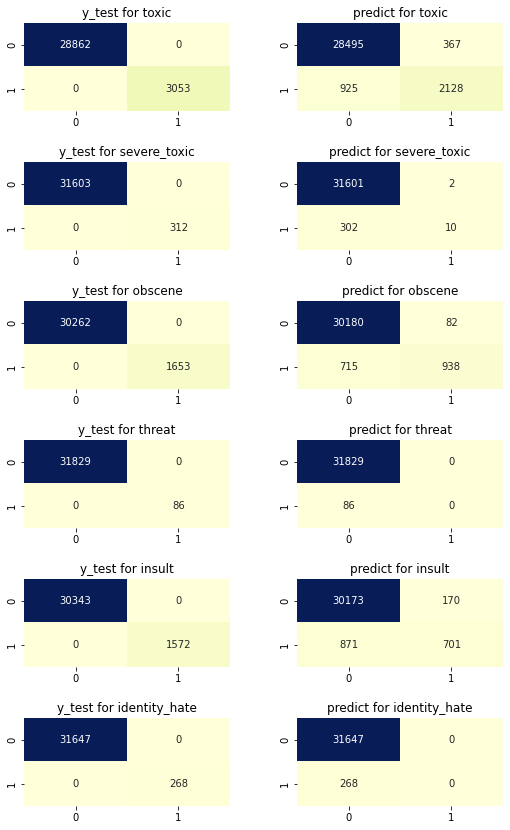

In [33]:
#create confusion matrix for all the categories. create one with the actual labels and another one with predictions
correct = multilabel_confusion_matrix(y_test, y_test)
result = multilabel_confusion_matrix(y_test, predict_classfied)

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(8, 12))
fig.tight_layout(pad=3.0)
for count in range(6):
  axes[count,0].set_title('y_test for ' + labels[count])
  sns.heatmap(correct[count], annot=True, ax=axes[count,0],cmap="YlGnBu", cbar=False,fmt='g')
  axes[count,1].set_title('predict for ' + labels[count])
  sns.heatmap(result[count], annot=True, ax=axes[count,1],cmap="YlGnBu", cbar=False,fmt='g')

In [34]:
#calculate precision, recall, f1
df_ = pd.DataFrame()
for cat in range(6):
  precision = precision_score(y_test[:,cat], [row[cat] for row in predict_classfied], average='macro')
  recall = recall_score(y_test[:,cat], [row[cat] for row in predict_classfied], average='macro')
  score = f1_score(y_test[:,cat], [row[cat] for row in predict_classfied], average='macro')
  row_df = pd.DataFrame([pd.Series([precision, recall, score])], index = [labels[cat]])
  df_ = pd.concat([df_, row_df])
df_.columns = ["Precision", "Recall", "F1"]
df_ = df_.round(2)
df_

Precision  Recall    F1
toxic               0.91    0.84  0.87
severe_toxic        0.91    0.52  0.53
obscene             0.95    0.78  0.84
threat              0.50    0.50  0.50
insult              0.89    0.72  0.78
identity_hate       0.50    0.50  0.50

**Final conclusion**

As we have pointed out from the first data analisys of the dataset the unbalancedness of different categories is a problem for the whole model.

We have shown how for different categories the model learn and then try to predict. We can assume that this model is correctly working for the toxic, obscene and insult categories. For the others categories we might need to make improvements either on the data or on the model.

**Future works**


1.   More data (More labelled comment expeccially those who had not a good F1 for our model)
2.   Better classification (toxic is the most labelled and sometimes is hard to differentiate other classes from each other)
3.   Classes removal (To increase the quality model take only the categories with enough data)
4.   Only toxicity classification (ignore the the different categories)
5.   Data selection (reduce the dataset, in particular the ones that are not relevant to the classification)
6.   Customization for the model based on each class ( for each class there could be an optimal model which could not be optimal for the other classes)



